> Code run locally due to server at 3.11 which is not supported by PyMOL



In [2]:
import os
from pathlib import Path
root = Path('/Users/user/Coding/EV-D68-3C-protease/')
os.chdir(root)

In [3]:
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
import pandas as pd
import ipywidgets as wd


metadata: pd.DataFrame = pd.read_csv('metadata-from-Fragalysis.csv',
                                     index_col=0)




PandasTools.AddMoleculeColumnToFrame(metadata, smilesCol='new_smiles', molCol='mol')
out = wd.Output()
with out:  # suppress output the crappy way
    metadata['single_smiles'] = metadata.mol.apply(LargestFragmentChooser(preferOrganic=True).choose).apply(Chem.MolToSmiles)

metadata.iloc[0]

crystal_name                                D68EV3CPROA-x0102_0B
RealCrystalName                                D68EV3CPROA-x0102
smiles                                            Cc1ccsc1C(=O)O
new_smiles                                        Cc1ccsc1C(=O)O
alternate_name                                        Z104474228
site_name                                                      5
pdb_entry                                                    NaN
mol                <rdkit.Chem.rdchem.Mol object at 0x13a1a28f0>
single_smiles                                     Cc1ccsc1C(=O)O
Name: 0, dtype: object

In [4]:
metadata.set_index('crystal_name').loc['D68EV3CPROA-x0102_0B']

RealCrystalName                                D68EV3CPROA-x0102
smiles                                            Cc1ccsc1C(=O)O
new_smiles                                        Cc1ccsc1C(=O)O
alternate_name                                        Z104474228
site_name                                                      5
pdb_entry                                                    NaN
mol                <rdkit.Chem.rdchem.Mol object at 0x13a1a28f0>
single_smiles                                     Cc1ccsc1C(=O)O
Name: D68EV3CPROA-x0102_0B, dtype: object

In [5]:
# NB. This is the Fragalysis download data
# this is for an asymmetric dimer but biological monomer

import pymol2
import chempy # from pymol installation
from pathlib import Path
from typing import List, Set, Dict, Tuple
import json

# ASSUMPTIONS: the PDBs have CONECT records. If not, use connect_mode = 1
# Fragalysis data is fine.
connect_mode = 0 # https://pymolwiki.org/index.php/Connect_mode

# data folder from Fragalysis download
folder = Path('workshop/D68EV3CPROA')
assert folder.exists()
fluff_marker = '§'  # name + fluff + index, say MPRO-x0102_0B§1
reference_chain = 'A'
skip_chains = []  # this is not the target protein, but a partner
lig_resn = 'LIG'

pdb_blocks: Dict[str, str] = {}
details: Dict[str, dict] = {}
for holo in (folder / Path('aligned')).glob('*/*.pdb'):
    #print(holo)
    with pymol2.PyMOL() as pymol:
        pymol.cmd.set('connect_mode',connect_mode)
        pymol.cmd.load('reference.pdb', 'ref')
        pymol_name = 'holo'
        pymol.cmd.load(str(holo.absolute()), pymol_name)
        # get info
        xstal_name: str = holo.name.rstrip('.pdb').rstrip('_bound').strip()
        xstal_info: pd.Series = metadata.set_index('crystal_name').loc[xstal_name]
        # ## Determine what is unique ligand residue
        # get atoms of ligand
        lig_atoms: List[chempy.Atom] = pymol.cmd.get_model(f'%{pymol_name} and resn {lig_resn}').atom
        # get set of tuple of resi chain segi alt
        selectors: Set[tuple] = {(atom.resi, atom.chain, atom.segi, atom.alt) for atom in lig_atoms}
        # iterate for all unique
        i = 0
        for resi, chain, segi, alt in selectors:
            sele = f'%{pymol_name} and resn {lig_resn} and resi {resi}'
            if chain:
                sele+= f' and chain {chain}'
            if segi:
                sele+= f' and segi {segi}'
            if alt:
                sele+= f' and alt {alt}'
            # figure out if it's in the wrong chain (asymmetric dimer)
            n_neigh = pymol.cmd.select('neighs', f'%{pymol_name} and polymer.protein and (byres {sele} around 3)')
            if not n_neigh:
                continue
            polymer_chains = pymol.cmd.get_chains('neighs')
            for polymer_chain in polymer_chains:
                if polymer_chain in skip_chains:
                    continue
                i += 1
                neoname = f'{xstal_name}{fluff_marker}{i}'
                pymol.cmd.align(f'%{pymol_name} and polymer.protein and chain {polymer_chain}',
                                 f'%ref and polymer.protein and chain {reference_chain}')
                pymol.cmd.create('copied', sele)
                pymol.cmd.alter('%copied', 'alt=""')
                pymol.cmd.alter('%copied', 'segi=""')
                pymol.cmd.alter('%copied', 'chain="X"')
                pymol.cmd.alter('%copied', 'resi="1"')
                pymol.cmd.sort()
                pdb_blocks[neoname] = pymol.cmd.get_pdbstr('%copied')
                pymol.cmd.delete('copied')
                details[neoname] = {**xstal_info.to_dict(),
                                    **dict(base_name=xstal_name,
                                        lig_resn=lig_resn,
                                         lig_resi=resi,
                                         lig_chain=chain,
                                         lig_segi=segi,
                                         lig_alt=alt,
                                         polymer_chain=polymer_chain,)
                                    }
            #pymol.cmd.create('modded', sele)
            #print(i, sele, n_neigh)

print('done')

done


Issue with sanitisation, trying without for D68EV3CPROA-x1064_0B§1
Issue with bond orders for D68EV3CPROA-x1064_0B§1 - AtomValenceExceptionExplicit valence for atom # 6 O, 3, is greater than permitted
Issue with sanitisation, trying without for D68EV3CPROA-x1064_0B§2
Issue with bond orders for D68EV3CPROA-x1064_0B§2 - AtomValenceExceptionExplicit valence for atom # 6 O, 3, is greater than permitted


[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] WARNING: More than one matching pattern found - picki

Issue with sanitisation, trying without for D68EV3CPROA-x1064_1B§1
Issue with bond orders for D68EV3CPROA-x1064_1B§1 - AtomValenceExceptionExplicit valence for atom # 6 O, 3, is greater than permitted
Issue with sanitisation, trying without for D68EV3CPROA-x1064_1B§2
Issue with bond orders for D68EV3CPROA-x1064_1B§2 - AtomValenceExceptionExplicit valence for atom # 6 O, 3, is greater than permitted


[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] Explicit valence for atom # 6 O, 3, is greater than permitted
[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] Explicit valence for atom # 6 O, 3, is greater than permitted
[11:58:47] Explicit valence for atom # 6 O, 3, is greater than permitted
[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] Explicit valence for atom # 6 O, 3, is greater than permitted
[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] WARNING: More than one matching pattern found - picking one

[11:58:47] WARNING: More than one matching pattern found - p

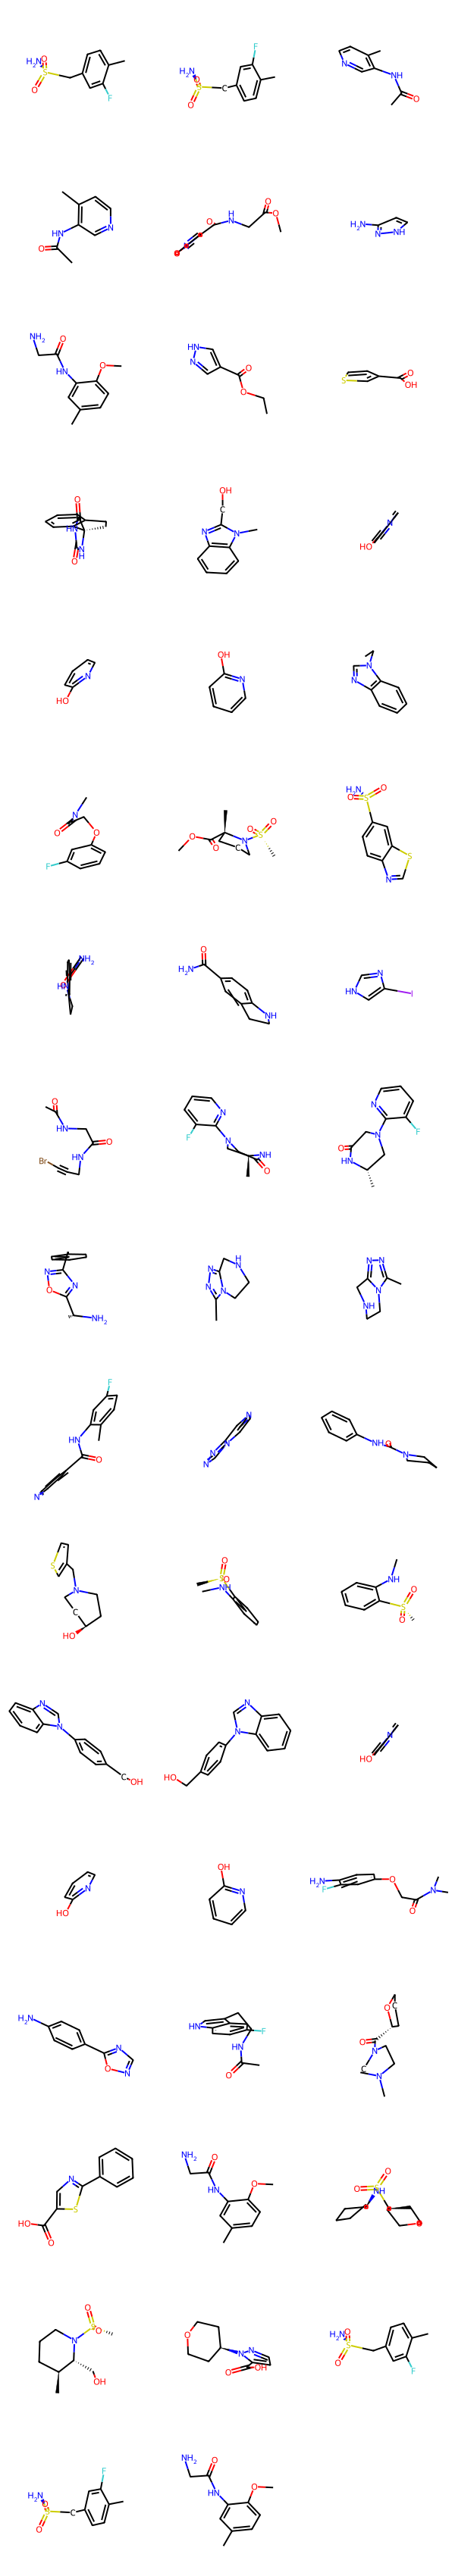

In [6]:
import json
import pickle
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

smiles_col_name = 'single_smiles'

mols = []
baddies = []
for name, block in pdb_blocks.items():
    detail: dict = details[name]
    mol = Chem.MolFromPDBBlock(block, proximityBonding='CONECT' not in block)
    if mol is None:
        print(f'Issue with sanitisation, trying without for {name}')
        mol = Chem.MolFromPDBBlock(block, proximityBonding='CONECT' not in block, sanitize=False)
    assert mol, f'{name} failed to load'
    assert mol.GetNumAtoms() > 0 and mol.GetNumBonds() > 0, f'{name} failed to load'
    ref = Chem.MolFromSmiles(detail[smiles_col_name])
    try:
        mol = AllChem.AssignBondOrdersFromTemplate(ref, mol)
    except Exception as e:
        print(f'Issue with bond orders for {name} - {e.__class__.__name__}{e}')
        baddies.append(dict(name=name, block=block, mol=mol, ref=ref, detail=detail, exception=e))
        continue
    mol.SetProp('XChem_code', name.split('_')[0])
    mol.SetProp('Occupancy', json.dumps([a.GetPDBResidueInfo().GetOccupancy() for a in mol.GetAtoms()]) )
    mol.SetProp('TempFactor', json.dumps([a.GetPDBResidueInfo().GetTempFactor() for a in mol.GetAtoms()]) )
    mol.SetProp('_Name', name)
    for k, v in detail.items():
        if isinstance(v, dict):
            v = json.dumps(v)
        mol.SetProp(k, str(v))
    for atom in mol.GetAtoms():
        name = atom.GetPDBResidueInfo().GetName()
        atom.SetProp('molFileAlias', name)
    mols.append(mol)

assert mols, 'No mols!'

Draw.MolsToGridImage(mols)

In [9]:
import operator

*map(operator.itemgetter('name'), baddies),

('D68EV3CPROA-x1064_0B§1',
 'D68EV3CPROA-x1064_0B§2',
 'D68EV3CPROA-x1064_1B§1',
 'D68EV3CPROA-x1064_1B§2')

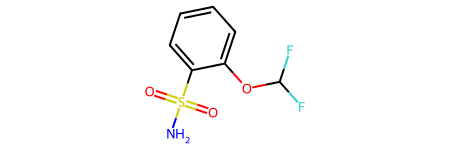

In [10]:
baddies[0]['ref']

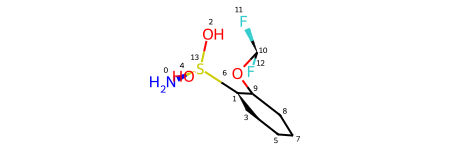

In [44]:
# error corrections based on failure of below...
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

baddies[0]['mol']

In [42]:
rwmol = Chem.RWMol(baddies[3]['mol'])
rwmol.RemoveBond(6, 12)
baddies[3]['mol'] = rwmol.GetMol()

In [48]:
## redux

for baddie in baddies:
    name = baddie['name']
    mol = AllChem.AssignBondOrdersFromTemplate(baddie['ref'], baddie['mol'])
    mol.SetProp('XChem_code', name.split('_')[0])
    mol.SetProp('Occupancy', json.dumps([a.GetPDBResidueInfo().GetOccupancy() for a in mol.GetAtoms()]) )
    mol.SetProp('TempFactor', json.dumps([a.GetPDBResidueInfo().GetTempFactor() for a in mol.GetAtoms()]) )
    mol.SetProp('_Name', name)
    for k, v in baddie['detail'].items():
        if isinstance(v, dict):
            v = json.dumps(v)
        mol.SetProp(k, str(v))
    for atom in mol.GetAtoms():
        name = atom.GetPDBResidueInfo().GetName()
        atom.SetProp('molFileAlias', name)
    mols.append(mol)

[12:15:25] WARNING: More than one matching pattern found - picking one

[12:15:25] WARNING: More than one matching pattern found - picking one

[12:15:25] WARNING: More than one matching pattern found - picking one

[12:15:25] WARNING: More than one matching pattern found - picking one



In [49]:
# Save

with Chem.SDWriter('hits.sdf') as sdf:
    for mol in mols:
        if mol is None:
            continue
        sdf.write(mol)